## Model Selection using RFE (Boom Bikes)

### Importing and Understanding Data

In [464]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [465]:
#Imports

import pandas as pd
import numpy as np
import calendar

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score

In [466]:
# Importing day.csv
bikes = pd.read_csv('day.csv')

## Data Preparation

In [467]:
# Data preparation

# instant is a index column or row counter
# Casual + registered = cnt and the target variables = cnt
# dteDay as season, month, weekday or working day is already extracted

dropColumns  = ['instant', 'casual', 'registered', 'dteday']
bikes = bikes.drop(columns = dropColumns, axis = 1)

In [468]:
# converting month to month name
bikes["mnth"] = bikes["mnth"].apply(lambda x: calendar.month_abbr[x])

In [469]:
# converting weekday to day name
bikes["weekday"] = bikes["weekday"].apply(lambda x: calendar.day_name[x])

In [470]:
# converting season to season name
def seasonMapper(x):
    return x.map({1: "spring" , 2: "summer", 3 : "fall", 4 : "winter"})

bikes[["season"]] = bikes[["season"]].apply(seasonMapper)

In [471]:
# converting weathersit params to weather types
def weatherMapper(x):
    return x.map({1: "clear" , 2: "misty", 3 : "light_snow", 4 : "heavy_snow"})

bikes[["weathersit"]] = bikes[["weathersit"]].apply(weatherMapper)

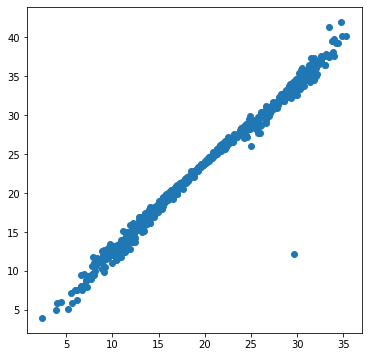

In [472]:
# performing scatter plot between temp and atemp
plt.figure(figsize=[6,6])
plt.scatter(bikes.temp, bikes.atemp)
plt.show()

In [473]:
# Instructor instructed to remove the variables. 
# checking the correlation between temp and atemp and then removing it
correlation = bikes.temp.corr(bikes.atemp)
print(correlation)

# 99% correlation between temp and atemp. so drop the column

bikes = bikes.drop(['atemp'], axis = 1)

0.9916961786905648


## Visualizing numeric variables

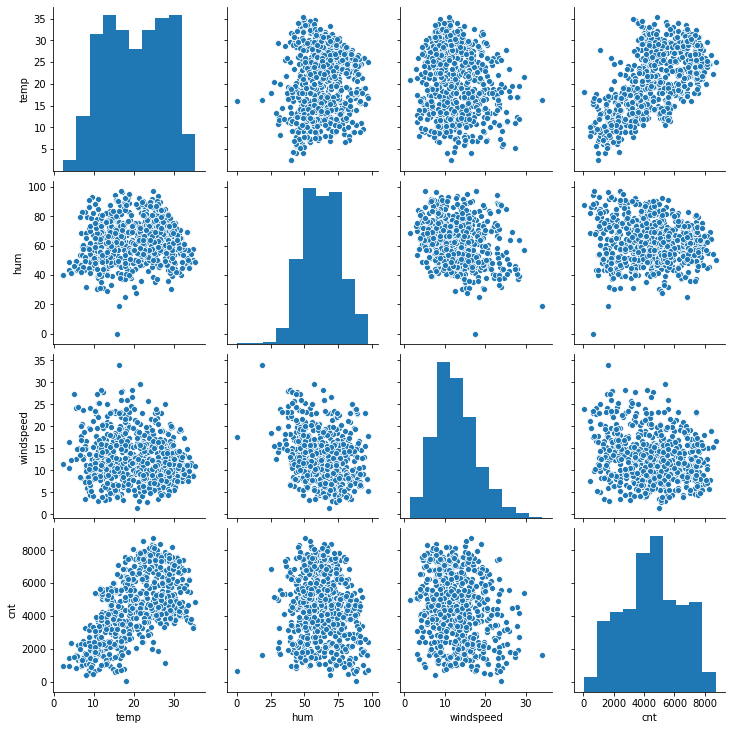

In [474]:
# Visualizing numeric variables, evaluating the pair plot

bikes_numeric = bikes.filter(['temp','hum','windspeed', 'cnt'], axis=1)

sns.pairplot(bikes_numeric)
plt.show()
# it shows we could be build a liner model against temp

## Visualizing categorical Variables

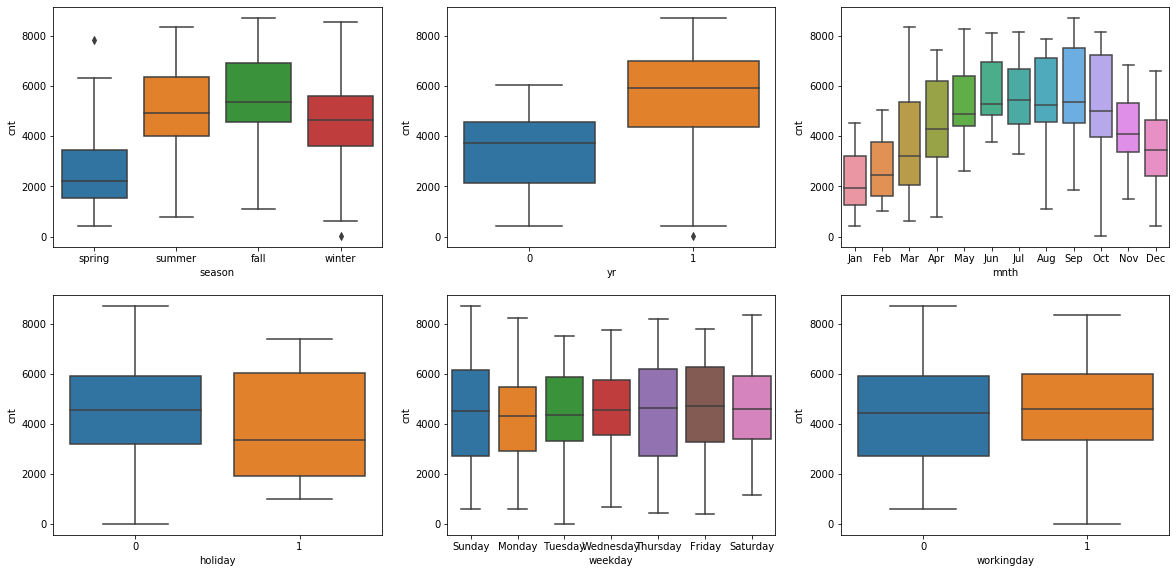

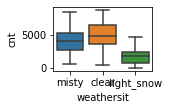

In [475]:
# visualizing categorical Variables in box plots

plt.figure(figsize=(20, 15))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = bikes)
plt.subplot(3,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = bikes)
plt.subplot(3,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = bikes)
plt.subplot(3,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = bikes)
plt.subplot(3,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = bikes)
plt.subplot(3,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = bikes)
plt.show()
plt.subplot(3,3,7)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bikes)
plt.show()

# shows that the weekdays have the same mean, though the variance is a little different

## Creating Dummy Variables

In [476]:
def getDummies(dataframe, column):
    # creating k-1 dummy variables
    dummyVariables = pd.get_dummies(dataframe[column], drop_first = True)
    # adding k-1 dummy variables to the dataframe
    dataframe = pd.concat([dataframe, dummyVariables], axis = 1)
    # dropping the actual columns
    dataframe.drop([column], axis = 1, inplace = True)
    return dataframe
    

In [477]:
# Converting weathersit to dummy variables
bikes = getDummies(bikes, "weathersit")
# Convering months to dummy variables
bikes = getDummies(bikes, "mnth")
# Convering Season to dummy variables
bikes = getDummies(bikes, "season")
# Convering weeekday to dummy variables
bikes = getDummies(bikes, "weekday")

## Creating Train and Test Data

In [478]:
# Spliting data into testing and training set
df_train, df_test = train_test_split(bikes, train_size = 0.75, test_size = 0.25, random_state = 100)

### Performing Scaling

In [479]:
# Perform scaling on training data

# Apply scaler() to all other than dummy variables and 0/1 variables
num_vars = [ 'temp', 'hum', 'windspeed', 'cnt']

scaler = MinMaxScaler()
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])


In [480]:
y_train = df_train.pop('cnt')
X_train = df_train

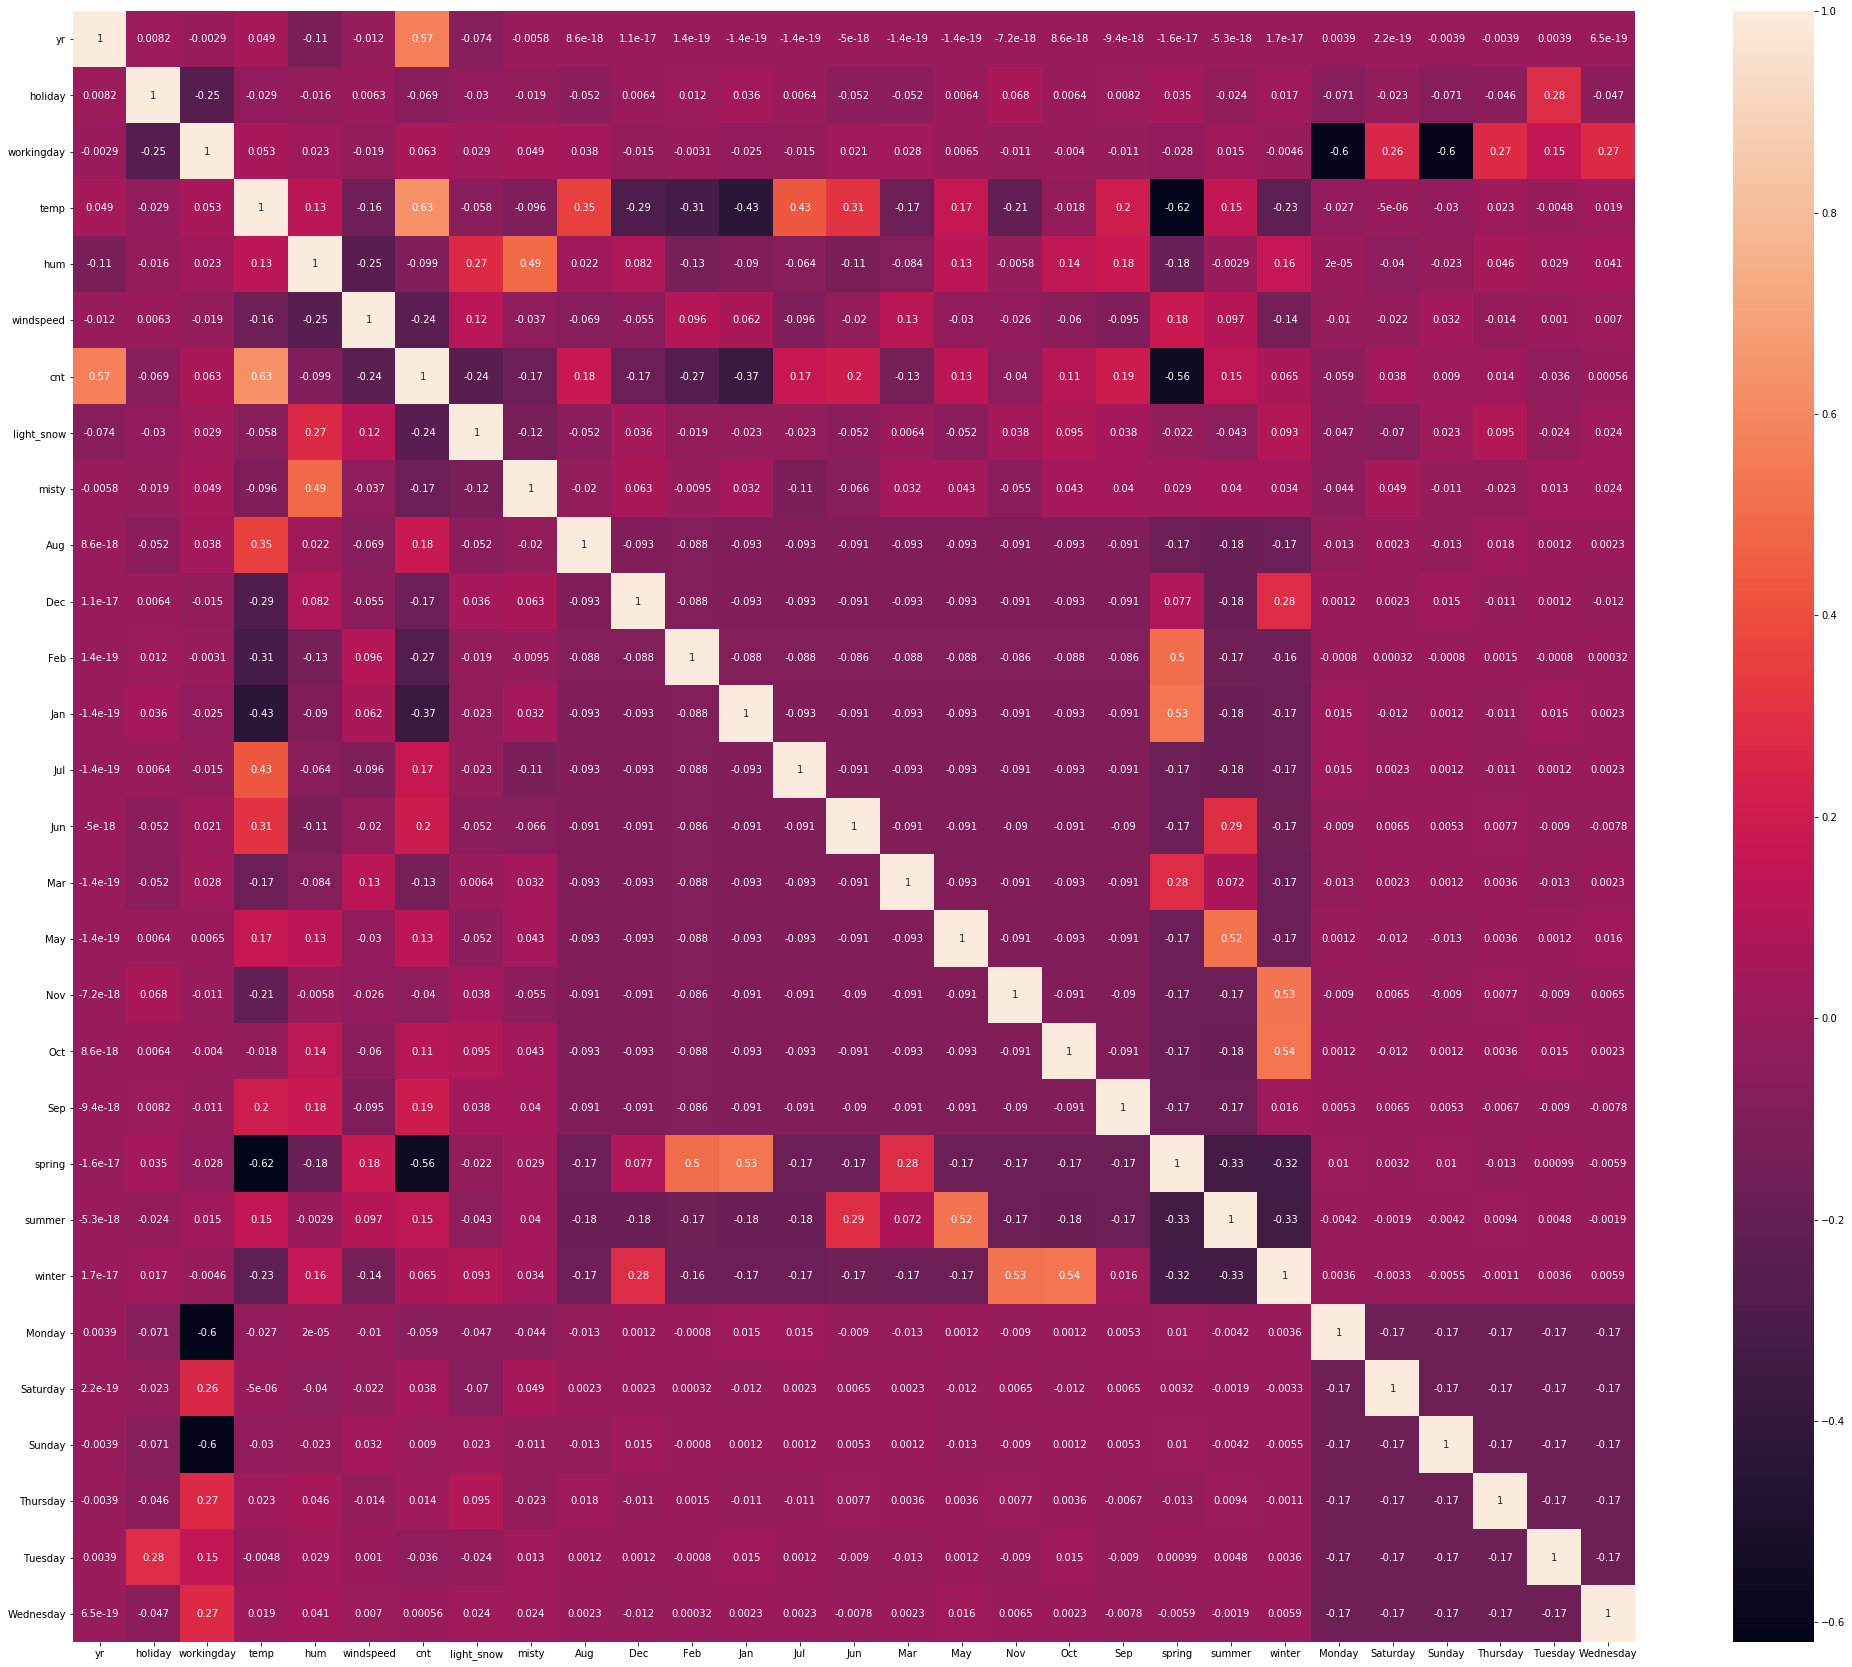

In [481]:
# Creating heat map to view the correlation
plt.figure(figsize = (35,30))        
sns.heatmap(bikes.corr(),annot = True)
plt.show()

# the target variabls seem to have high correlatin with yr, temp, spring season, Jan month

### Defining function to derive Linear regression and VIF

In [482]:
def getLinearRegressionStats(X_train, X_train_columns): 
    # Add a constant
    X_train_lm = sm.add_constant(X_train_columns)
    # Create a first fitted model
    lr = sm.OLS(y_train, X_train_lm).fit()
    return lr

def checkVIF(X_train_columns):
    vif = pd.DataFrame()
    vif['Features'] = X_train_columns.columns
    vif['VIF'] = [variance_inflation_factor(X_train_columns.values, i) for i in range(X_train_columns.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

In [483]:
def getLRSummaryAndVIF(X_train, X_train_columns): 
    #X_train_columns = 
    lr_model = getLinearRegressionStats(X_train, X_train_columns)
    print(lr_model.summary())
    if len(X_train_columns.columns) > 1 :
        print('')
        print('')
        print('')
        print('----------------------  GET VIF INFORMATION  -- ------------------------------')
        print('==============================================================================')
        checkVIF(X_train_columns)
    return lr_model

## Running RFE (Recursive feature Elimination)

In [484]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

# running RFE
rfe = RFE(lm, 12)             
rfe = rfe.fit(X_train, y_train)

zip(X_train.columns,rfe.support_,rfe.ranking_)

In [485]:
# getting all of the RFE support columns
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]
lr_model = getLRSummaryAndVIF(X_train, X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     242.4
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          4.14e-207
Time:                        20:52:13   Log-Likelihood:                 549.95
No. Observations:                 547   AIC:                            -1074.
Df Residuals:                     534   BIC:                            -1018.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2806      0.033      8.406      0.0

In [486]:
# Dropping variables are having high VIF and modeling it
# Ran multiple models by removing each of the variable's one at a time. Ensuring the VIF < 5 and P>[t] < 0.05. 
# which defines that the multicolinarity is less and null hypothesis is rejected
dropVariables = ["hum", "Jul", "Sep", "windspeed"]
X_train_new = X_train_rfe.drop(dropVariables, axis = 1)
lr_model_final = getLRSummaryAndVIF(X_train, X_train_new)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     295.5
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          2.34e-191
Time:                        20:52:14   Log-Likelihood:                 501.19
No. Observations:                 547   AIC:                            -984.4
Df Residuals:                     538   BIC:                            -945.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1640      0.028      5.819      0.0

## Performing model analysis on Test Data

In [487]:
# for test data only transform the variabless
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [488]:
X = df_test[X_train_new.columns]
X = sm.add_constant(X)
Predicted_cnt = lr_model_final.predict(X)

In [489]:
mse = mean_squared_error(df_test.cnt, Predicted_cnt)
r_squared = r2_score(df_test.cnt, Predicted_cnt)

print('Mean Squared Error :' ,mse)
print('R square value :',r_squared)

# An R-Square of 79% is close to 81%, is ensuring the model is well defined and the not doing the "best fit"

Mean Squared Error : 0.009755917386332432
R square value : 0.7893245224995302


## Evaluating Linear Regression Assumptions

Text(0, 0.5, 'Count')

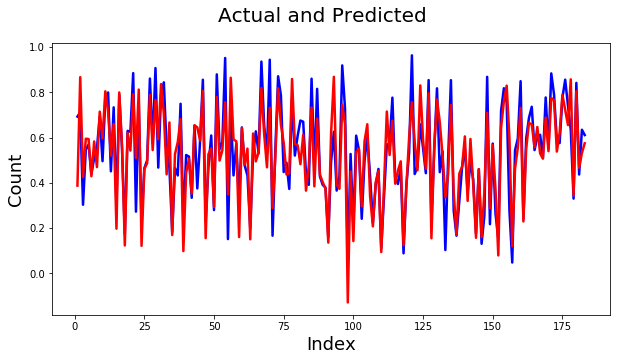

In [490]:
#Actual vs Predicted Count
c = [i for i in range(1,184,1)]
fig = plt.figure(figsize=(10, 5))
plt.plot(c, df_test.cnt, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c, Predicted_cnt, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Count', fontsize=18)   

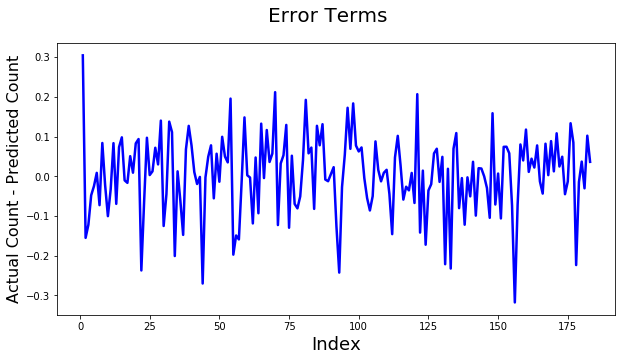

In [491]:
# Error terms
c = [i for i in range(1,184,1)]
fig = plt.figure(figsize=(10, 5))
plt.plot(c,df_test.cnt-Predicted_cnt, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('Actual Count - Predicted Count', fontsize=16)   # Y-label
plt.show()

# plot indicates the error terms are independant

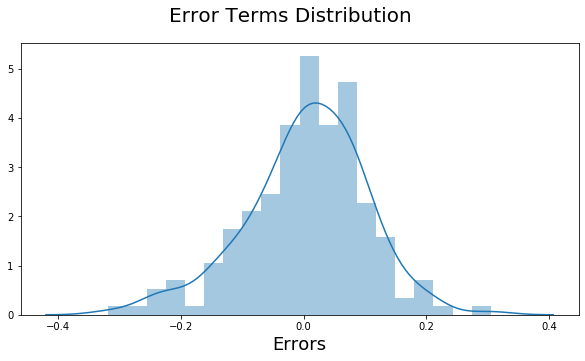

In [492]:
# Plot the histogram of the error terms
fig = plt.figure(figsize=(10, 5))
sns.distplot((df_test.cnt-Predicted_cnt), bins = 20)
fig.suptitle('Error Terms Distribution', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)   
plt.show()

# This distribution ensures the mean is zero and variance is constants